## Parte 2. Selección e Ingeniería de caracteristicas

In [1]:
# Importación de librerias
import numpy as np
import pandas as pd

In [2]:
df_processed = pd.read_csv('../data/processed/bike_sharing_processed.csv')
df_fe = df_processed.copy()

In [3]:
df_fe.shape

(17531, 17)

In [4]:
# Revisando tipado de datos
df_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17531 entries, 0 to 17530
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      17531 non-null  object 
 1   season      17531 non-null  int64  
 2   yr          17531 non-null  int64  
 3   mnth        17531 non-null  int64  
 4   hr          17531 non-null  int64  
 5   holiday     17531 non-null  int64  
 6   weekday     17531 non-null  int64  
 7   workingday  17531 non-null  int64  
 8   weathersit  17531 non-null  int64  
 9   temp        17531 non-null  float64
 10  atemp       17531 non-null  float64
 11  hum         17531 non-null  float64
 12  windspeed   17531 non-null  float64
 13  casual      17531 non-null  int64  
 14  registered  17531 non-null  float64
 15  cnt         17531 non-null  float64
 16  instant     17531 non-null  int64  
dtypes: float64(6), int64(10), object(1)
memory usage: 2.3+ MB


In [5]:
df_fe.head(5)

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,instant
0,2011-01-01,1,0,1,0,0,5,0,1,0.24,0.2879,0.81,0.0,3,13.0,16.0,0
1,2011-01-01,1,0,1,1,0,5,0,1,0.22,0.2727,0.80,0.0,8,32.0,40.0,1
2,2011-01-01,1,0,1,2,0,5,0,1,0.22,0.2727,0.80,0.0,5,27.0,32.0,2
3,2011-01-01,1,0,1,3,0,5,0,1,0.24,0.2879,0.75,0.0,3,10.0,13.0,3
4,2011-01-01,1,0,1,4,0,5,0,1,0.24,0.2879,0.75,0.0,0,1.0,2.0,4


In [6]:
# fechas
if not np.issubdtype(df_fe['dteday'].dtype, np.datetime64):
    df_fe['dteday'] = pd.to_datetime(df_fe['dteday'], errors='coerce')

# datos con tipo de dato entero
for c in ['season','yr','mnth','hr','holiday','weekday','workingday','weathersit','instant']:
    if c in df_fe:
        df_fe[c] = pd.to_numeric(df_fe[c], errors='coerce').round().astype('Int64')

# datos con tipo de dato continuo
for c in ['temp','atemp','hum','windspeed','cnt']:
    if c in df_fe:
        df_fe[c] = pd.to_numeric(df_fe[c], errors='coerce')

### Generamos más variables a partir de las existentes para ayudar a la interpretabilidad

In [10]:
# Temporales derivadas
df_fe['dayofyear'] = df_fe['dteday'].dt.dayofyear
df_fe['is_weekend'] = df_fe['weekday'].isin([0,6]).astype(int)

# Codificación cíclica: ayuda a que el modelo entienda que son ciclos
# hora (0-23)
df_fe['hr_sin']  = np.sin(2*np.pi * df_fe['hr'].astype(float) / 24.0)
df_fe['hr_cos']  = np.cos(2*np.pi * df_fe['hr'].astype(float) / 24.0)

# mes (1-12)
df_fe['mnth_sin'] = np.sin(2*np.pi * df_fe['mnth'].astype(float) / 12.0)
df_fe['mnth_cos'] = np.cos(2*np.pi * df_fe['mnth'].astype(float) / 12.0)

# día del año (1-366)
df_fe['doy_sin'] = np.sin(2*np.pi * df_fe['dayofyear'].astype(float) / 366.0)
df_fe['doy_cos'] = np.cos(2*np.pi * df_fe['dayofyear'].astype(float) / 366.0)

# Interacciones climáticas simples (no lineales y combinaciones útiles)
df_fe['temp_diff']  = df_fe['atemp'] - df_fe['temp']       # sensación - temperatura
df_fe['temp_x_hum'] = df_fe['temp'] * df_fe['hum']         # bochorno aproximado
df_fe['wind_sq']    = df_fe['windspeed'] ** 2              # relación no lineal con viento

# Lags de cnt
df_fe = df_fe.sort_values(by='dteday')
df_fe['cnt_lag1'] = df_fe['cnt'].shift(1)
df_fe['cnt_lag24'] = df_fe['cnt'].shift(24)
df_fe['cnt_rolling_mean'] = df_fe['cnt'].rolling(window=3).mean()

In [14]:
# 1. Transformación logarítmica (log1p)
# Esto reduce la asimetría y mejora la distribución para el modelado
df_fe['cnt_log'] = np.log1p(df_fe['cnt'])
df_fe['cnt_lag1_log'] = np.log1p(df_fe['cnt_lag1'])
df_fe['cnt_lag24_log'] = np.log1p(df_fe['cnt_lag24'])
df_fe['cnt_rolling_mean_log'] = np.log1p(df_fe['cnt_rolling_mean'])
df_fe['casual_log'] = np.log1p(df_fe['casual'])
df_fe['registered_log'] = np.log1p(df_fe['registered'])


<Axes: >

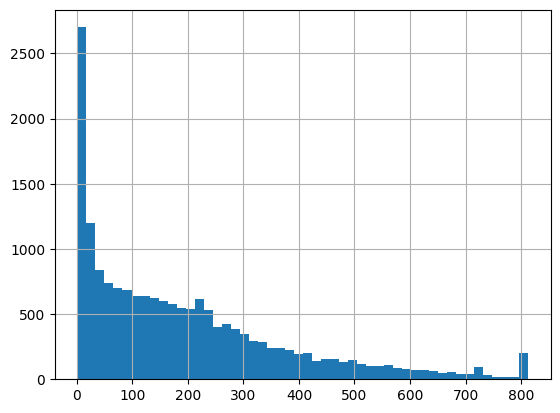

In [15]:
df_fe['cnt'].hist(bins=50)

<Axes: >

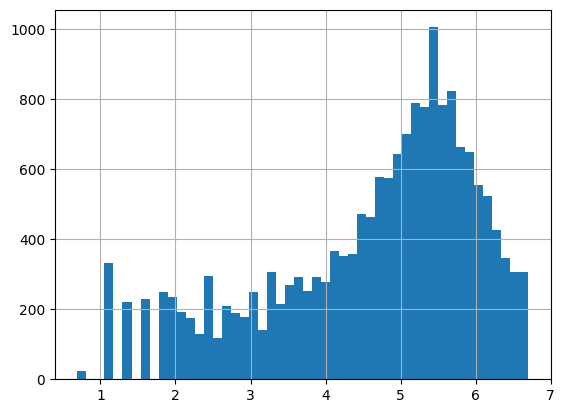

In [16]:
df_fe['cnt_log'].hist(bins=50)

In [17]:
df_fe.columns

Index(['dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt', 'instant', 'dayofyear', 'is_weekend',
       'hr_sin', 'hr_cos', 'mnth_sin', 'mnth_cos', 'doy_sin', 'doy_cos',
       'temp_diff', 'temp_x_hum', 'wind_sq', 'cnt_lag1', 'cnt_lag24',
       'cnt_rolling_mean', 'cnt_log', 'cnt_lag1_log', 'cnt_lag24_log',
       'cnt_rolling_mean_log', 'casual_log', 'registered_log'],
      dtype='object')

## Encodings

In [19]:
# 2. Codificación One-Hot para Categóricas Nominales/Ordinales
categorical_cols = ['season', 'weekday', 'weathersit']

# Convertir a 'category' para asegurar que get_dummies funcione correctamente
for col in categorical_cols:
    df_fe[col] = df_fe[col].astype('category')

In [32]:
from sklearn.preprocessing import OneHotEncoder

df_to_encode = df_fe.copy()
# Aplicar One-Hot Encoding usando sklearn
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
encoded = encoder.fit_transform(df_to_encode[categorical_cols])
encoded_cols = encoder.get_feature_names_out(categorical_cols)
df_encoded = pd.DataFrame(encoded, columns=encoded_cols, index=df_to_encode.index)

# Combinar con el DataFrame original sin las columnas categóricas
df_model = pd.concat([df_to_encode.drop(columns=categorical_cols), df_encoded], axis=1)


In [33]:
print("Shape original:", df_fe.shape)
print("Shape con one-hot:", df_model.shape)
print("Nuevas columnas:", list(encoded_cols))
df_model.head(3)


Shape original: (17531, 37)
Shape con one-hot: (17531, 46)
Nuevas columnas: ['season_2', 'season_3', 'season_4', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weathersit_2', 'weathersit_3', 'weathersit_4']


,dteday,yr,mnth,hr,holiday,workingday,temp,atemp,hum,windspeed,...,season_4,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3,weathersit_4
0,2011-01-01,0,1,0,0,0,0.24,0.2879,0.81,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,2011-01-01,0,1,6,0,0,0.22,0.2727,0.80,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,2011-01-01,0,1,9,0,0,0.32,0.3485,0.76,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


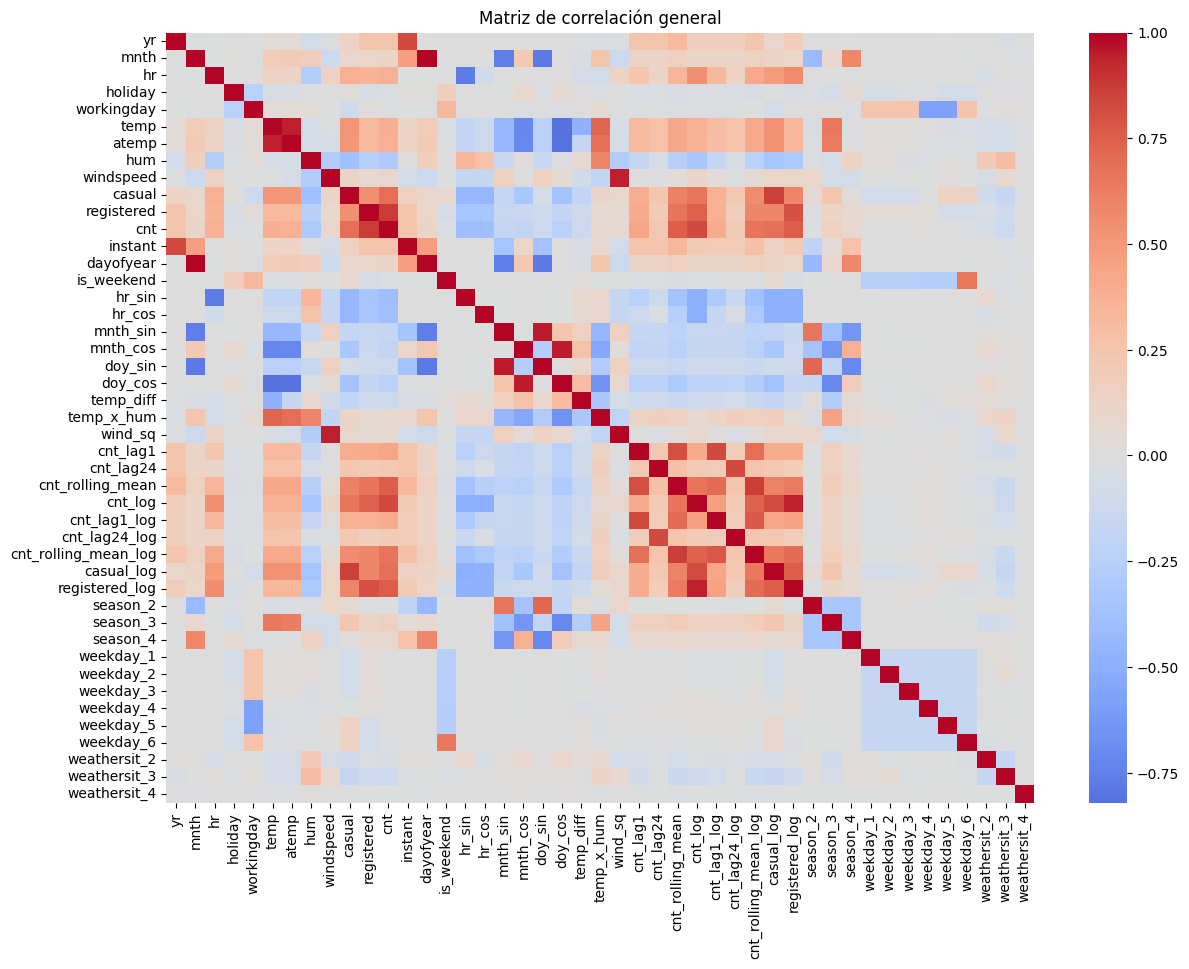

🔹 Correlación con 'cnt':
cnt                     1.000000
registered              0.876706
cnt_log                 0.822954
registered_log          0.764276
cnt_rolling_mean        0.756067
casual                  0.691488
casual_log              0.682711
cnt_rolling_mean_log    0.661127
cnt_lag1                0.438882
cnt_lag1_log            0.402022
temp                    0.381876
atemp                   0.381048
hr                      0.378113
instant                 0.259044
yr                      0.240245
Name: cnt, dtype: float64

🔻 Menor correlación con 'cnt':
weathersit_2   -0.048197
doy_sin        -0.116559
weathersit_3   -0.123612
temp_diff      -0.128697
mnth_sin       -0.169168
mnth_cos       -0.190583
doy_cos        -0.230442
hum            -0.302089
hr_cos         -0.390546
hr_sin         -0.394179
Name: cnt, dtype: float64

⚠️ Pares altamente correlacionados (>0.9):


,feature_1,feature_2,corr
55,mnth,dayofyear,0.996493
210,temp,atemp,0.943948
338,windspeed,wind_sq,0.947221
613,mnth_sin,doy_sin,0.953208
640,mnth_cos,doy_cos,0.953027
841,cnt_log,registered_log,0.947559


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Aseguramos que 'cnt' sea numérica
df_corr = df_model.copy()
df_corr['cnt'] = pd.to_numeric(df_corr['cnt'], errors='coerce')

# Correlaciones solo numéricas
corr = df_corr.corr(numeric_only=True)

# --- 1️⃣ Matriz de correlación general ---
plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Matriz de correlación general")
plt.show()

# --- 2️⃣ Correlación con la variable objetivo ---
target_corr = corr['cnt'].sort_values(ascending=False)
print("🔹 Correlación con 'cnt':")
print(target_corr.head(15))
print("\n🔻 Menor correlación con 'cnt':")
print(target_corr.tail(10))

# --- 3️⃣ Identificar pares altamente correlacionados (>0.9) ---
threshold = 0.9
high_corr_pairs = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    .stack()
    .reset_index()
    .rename(columns={'level_0': 'feature_1', 'level_1': 'feature_2', 0: 'corr'})
)
high_corr_pairs = high_corr_pairs.loc[abs(high_corr_pairs['corr']) > threshold]
print("\n⚠️ Pares altamente correlacionados (>0.9):")
display(high_corr_pairs)


In [37]:
# Columnas que SE MANTIENEN en X (ejemplo basado en el análisis):
features_to_keep = [
    'yr', 'holiday', 'workingday', 
    
    # Clima (se mantiene solo temp y las interacciones)
    'temp', 'hum', 'windspeed', 'temp_diff', 'temp_x_hum', 'wind_sq',
    
    # Tiempo
    'is_weekend', 
    'hr_sin', 'hr_cos', 'mnth_sin', 'mnth_cos', 'doy_sin', 'doy_cos',
    
    # Lags Transformados (excluyendo los crudos)
    'cnt_lag1_log', 'cnt_lag24_log', 'cnt_rolling_mean_log',
    
    # OHEs
    'season_2', 'season_3', 'season_4', 
    'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
    'weathersit_2', 'weathersit_3', 'weathersit_4'
]

X = df_model[features_to_keep]
y = df_model['cnt_log']

In [35]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17531 entries, 0 to 17174
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   yr                    17531 non-null  Int64  
 1   holiday               17531 non-null  Int64  
 2   workingday            17531 non-null  Int64  
 3   temp                  17531 non-null  float64
 4   hum                   17531 non-null  float64
 5   windspeed             17531 non-null  float64
 6   temp_diff             17531 non-null  float64
 7   temp_x_hum            17531 non-null  float64
 8   wind_sq               17531 non-null  float64
 9   is_weekend            17531 non-null  int64  
 10  hr_sin                17531 non-null  float64
 11  hr_cos                17531 non-null  float64
 12  mnth_sin              17531 non-null  float64
 13  mnth_cos              17531 non-null  float64
 14  doy_sin               17531 non-null  float64
 15  doy_cos               17

Se eliminan los nulos de lags para evitar que con imputaciones se introduzcan sesgos al dataset.

In [ ]:
lag_columns = ['cnt_lag1_log', 'cnt_lag24_log', 'cnt_rolling_mean_log']
y = df_model['cnt_log']
df_clean = pd.concat([X, y], axis=1).dropna(subset=lag_columns)
print(f"Filas originales: {len(X)}")
X = df_clean.drop(columns='cnt_log')
y = df_clean['cnt_log']
print(f"Filas después de eliminar nulos: {len(X)}")

Filas originales: 17531
Filas después de eliminar nulos: 17507


In [41]:
# Definimos el porcentaje de datos que irá a Entrenamiento (e.g., 80%)
train_ratio = 0.80

# Calcular el punto de corte basado en el porcentaje
split_point_percentual = int(len(X) * train_ratio)

# Aplicar la división sin barajar (manteniendo el orden temporal)
X_train = X.iloc[:split_point_percentual]
X_val = X.iloc[split_point_percentual:]
y_train = y.iloc[:split_point_percentual]
y_val = y.iloc[split_point_percentual:]

print(f"Split Point (Row Index): {split_point_percentual}")
print(f"Tamaño de X_train (80%): {len(X_train)}")
print(f"Tamaño de X_val (20%): {len(X_val)}")

Split Point (Row Index): 14005
Tamaño de X_train (80%): 14005
Tamaño de X_val (20%): 3502


### Evaluacion de importancia de caractarísticas

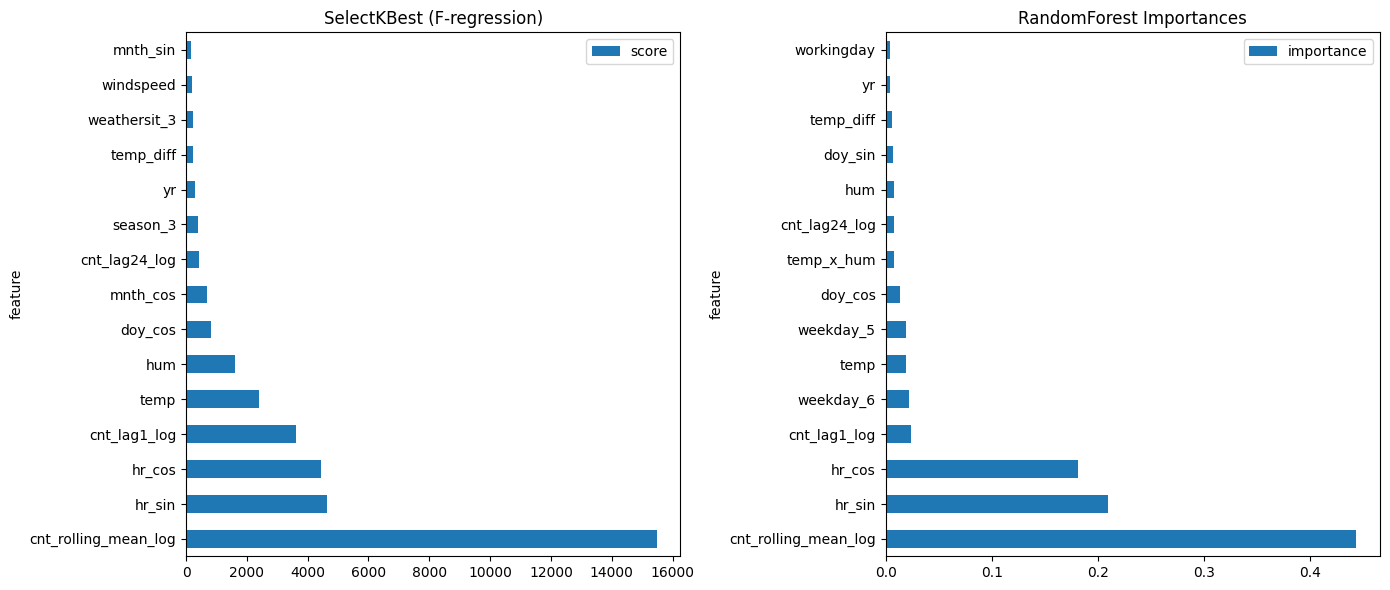

🔹 Top 10 ANOVA:


,feature,score
18,cnt_rolling_mean_log,15483.826657
10,hr_sin,4626.505389
11,hr_cos,4451.035122
16,cnt_lag1_log,3612.972344
3,temp,2398.282829
4,hum,1599.874266
15,doy_cos,816.184640
13,mnth_cos,679.275363
17,cnt_lag24_log,416.080555
20,season_3,378.604599



🔹 Top 10 RF:


,feature,importance
18,cnt_rolling_mean_log,0.444036
10,hr_sin,0.209667
11,hr_cos,0.181103
16,cnt_lag1_log,0.023882
27,weekday_6,0.022450
3,temp,0.019552
26,weekday_5,0.019348
15,doy_cos,0.013309
7,temp_x_hum,0.008004
17,cnt_lag24_log,0.007657


In [42]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


# 1) quitar columnas datetime (p. ej., 'dteday')
dt_cols = X.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns
X = X.drop(columns=dt_cols)

# 2) forzar numérico en todo (nullable Int64 -> float)
for c in X.columns:
    X[c] = pd.to_numeric(X[c], errors='coerce')

# 3) asegurar sin NaN (no debería haber, pero por si acaso)
if X.isna().any().any():
    X = X.fillna(0.0)

# --- SelectKBest (ANOVA/F-test)
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X_train, y_train) # <- Usar el set de entrenamiento TEMPORAL
anova_scores = pd.DataFrame(
    {'feature': X_train.columns, 'score': selector.scores_}
).sort_values('score', ascending=False)

# --- Random Forest Importances
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train) # <- Usar el set de entrenamiento TEMPORAL
rf_importances = pd.DataFrame(
    {'feature': X_train.columns, 'importance': rf.feature_importances_}
).sort_values('importance', ascending=False)


# --- plots rápidos
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
anova_scores.head(15).plot.barh(x='feature', y='score', ax=axes[0])
axes[0].set_title('SelectKBest (F-regression)')
rf_importances.head(15).plot.barh(x='feature', y='importance', ax=axes[1])
axes[1].set_title('RandomForest Importances')
plt.tight_layout()
plt.show()

print("🔹 Top 10 ANOVA:")
display(anova_scores.head(10))
print("\n🔹 Top 10 RF:")
display(rf_importances.head(10))


### Entrenamiento de modelos

In [43]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score


models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(random_state=42),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost Regressor": xgb.XGBRegressor(
        n_estimators=200, 
        learning_rate=0.1, 
        max_depth=5, 
        random_state=42, 
        n_jobs=-1
    )
}

results = []


def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    # Entrenar
    model.fit(X_train, y_train)
    
    # Predecir en escala logarítmica
    y_pred_log = model.predict(X_val)
    
    # Deshacer la transformación Logarítmica (Inverse Transform)
    # np.expm1(x) es lo mismo que np.exp(x) - 1
    y_val_original = np.expm1(y_val)
    y_pred_original = np.expm1(y_pred_log)
    
    # Forzar a que las predicciones de conteo sean al menos 0
    y_pred_original[y_pred_original < 0] = 0

    # Calcular Métricas en ambas escalas
    rmse_log = np.sqrt(mean_squared_error(y_val, y_pred_log))
    r2_log = r2_score(y_val, y_pred_log)
    
    rmse_original = np.sqrt(mean_squared_error(y_val_original, y_pred_original))
    
    return {
        'Modelo': model_name,
        'RMSE_log': rmse_log,
        'R2_log': r2_log,
        'RMSE_original': rmse_original
    }

print("\nIniciando entrenamiento y evaluación...")
for name, model in models.items():
    print(f"-> Entrenando {name}...")
    metrics = evaluate_model(model, X_train, y_train, X_val, y_val, name)
    results.append(metrics)

# Crear DataFrame de resultados
results_df = pd.DataFrame(results)

print("\n" + "="*50)
print("Comparativa de Modelos en Conjunto de Validación")
print("="*50)
print(results_df.sort_values(by='RMSE_original'))
print("="*50)


best_model_name = results_df.loc[results_df['RMSE_original'].idxmin()]['Modelo']
print(f"El mejor modelo para la optimización es: {best_model_name}")



Iniciando entrenamiento y evaluación...
-> Entrenando Linear Regression...
-> Entrenando Ridge Regression...
-> Entrenando Random Forest Regressor...
-> Entrenando XGBoost Regressor...

Comparativa de Modelos en Conjunto de Validación
                    Modelo  RMSE_log    R2_log  RMSE_original
3        XGBoost Regressor  0.426318  0.905291      83.477551
2  Random Forest Regressor  0.453470  0.892842      87.568433
1         Ridge Regression  0.722260  0.728160     152.095093
0        Linear Regression  0.722149  0.728244     152.189581
El mejor modelo para la optimización es: XGBoost Regressor


### Optimización de modelo ganador

In [45]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error, make_scorer

# 1. Definir la Métrica de Puntuación (Scoring)
# GridSearchCV busca maximizar la puntuación. Usamos el negativo del RMSE.
# Multiplicamos por -1 para maximizar el resultado (minimizar el error).
rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

# 2. Configurar Time Series Cross-Validation
# Vamos a usar 5 splits, lo que significa que el modelo se entrena 5 veces, 
# cada vez con más datos y validando en el siguiente segmento de tiempo.
tscv = TimeSeriesSplit(n_splits=5) 

# 3. Definir la Búsqueda de Hiperparámetros (Grid)
# Hemos elegido un rango inicial basado en buenas prácticas para problemas de regresión:
param_grid = {
    'n_estimators': [200, 400], 
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.7, 0.9] 
}

# 4. Instanciar y Ejecutar GridSearchCV
xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=xgb_model, 
    param_grid=param_grid, 
    scoring=rmse_scorer, # Usamos la métrica RMSE (negativa)
    cv=tscv, 
    verbose=2, 
    n_jobs=-1 
)

print("\nIniciando búsqueda de hiperparámetros con TimeSeriesSplit...")

# Ajustamos la búsqueda sobre el conjunto de entrenamiento (X_train, y_train)
grid_search.fit(X_train, y_train) 

print("\n" + "="*50)
print("Resultados de la Búsqueda de Hiperparámetros")
print("="*50)
print(f"Mejor RMSE_log (negativo): {grid_search.best_score_}")
print(f"Mejores Parámetros: {grid_search.best_params_}")


Iniciando búsqueda de hiperparámetros con TimeSeriesSplit...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Resultados de la Búsqueda de Hiperparámetros
Mejor RMSE_log (negativo): -0.5064835973537256
Mejores Parámetros: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 400, 'subsample': 0.9}


In [46]:
# Extraer el mejor modelo
best_xgb = grid_search.best_estimator_ 

# Evaluar el modelo optimizado en el conjunto de validación
y_pred_log_optimized = best_xgb.predict(X_val)

# Deshacer la transformación Logarítmica
y_val_original = np.expm1(y_val)
y_pred_original_optimized = np.expm1(y_pred_log_optimized)

# Calcular RMSE final
final_rmse_original = np.sqrt(mean_squared_error(y_val_original, y_pred_original_optimized))
final_r2_log = r2_score(y_val, y_pred_log_optimized)

print("\n" + "="*50)
print("✅ Rendimiento del Modelo Final Optimizado")
print("="*50)
print(f"RMSE Logarítmico Final (Validación): {final_r2_log:.4f}")
print(f"R2 Logarítmico Final (Validación): {final_r2_log:.4f}")
print(f"RMSE Original (Validación): {final_rmse_original:.2f} bicicletas")
print("="*50)


✅ Rendimiento del Modelo Final Optimizado
RMSE Logarítmico Final (Validación): 0.9045
R2 Logarítmico Final (Validación): 0.9045
RMSE Original (Validación): 83.43 bicicletas


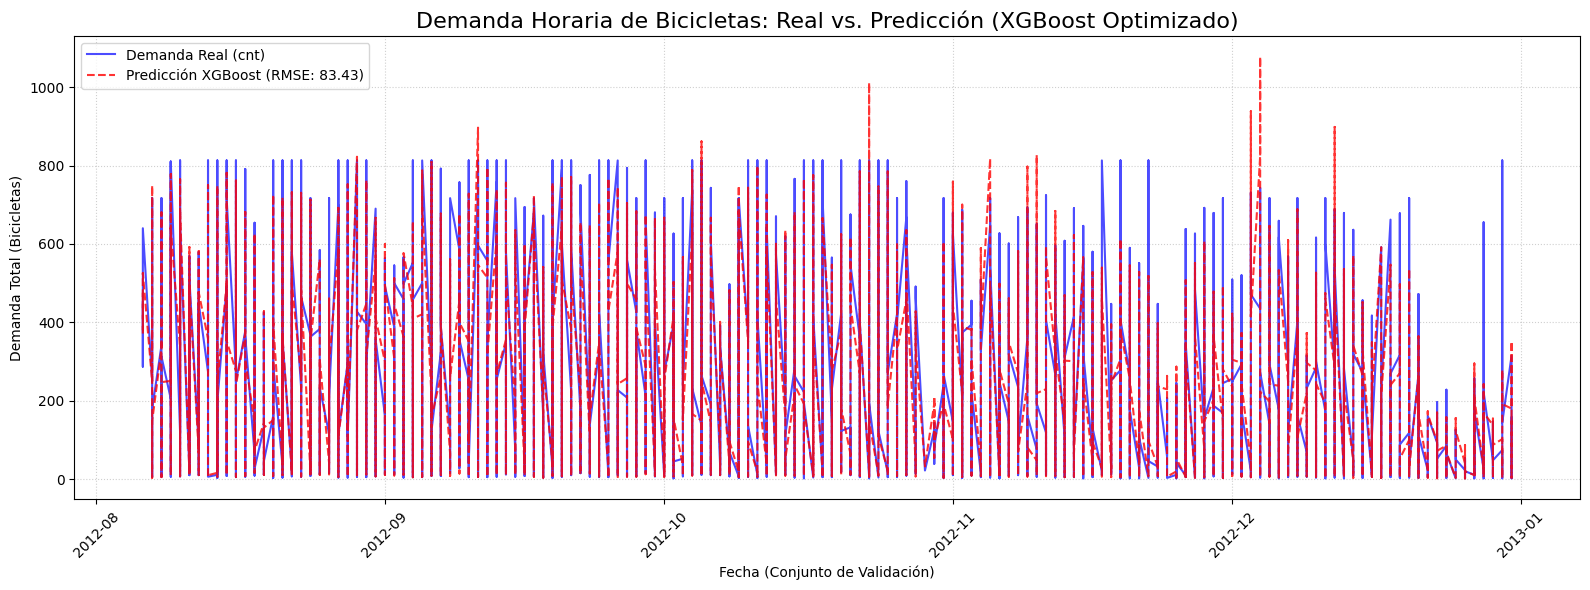

In [48]:
import matplotlib.pyplot as plt

valid_dates = df_model.loc[X_val.index, 'dteday']
y_pred_log = best_xgb.predict(X_val)
y_val_original = np.expm1(y_val)
y_pred_original = np.expm1(y_pred_log)


plt.figure(figsize=(16, 6))

# Trazar valores reales
plt.plot(valid_dates, y_val_original, 
         label='Demanda Real (cnt)', 
         color='blue', 
         alpha=0.7)

# Trazar predicciones de XGBoost
plt.plot(valid_dates, y_pred_original, 
         label=f'Predicción XGBoost (RMSE: {83.43:.2f})', # Usamos tu RMSE final
         color='red', 
         linestyle='--', 
         alpha=0.8)

plt.title('Demanda Horaria de Bicicletas: Real vs. Predicción (XGBoost Optimizado)', fontsize=16)
plt.xlabel('Fecha (Conjunto de Validación)')
plt.ylabel('Demanda Total (Bicicletas)')
plt.legend(loc='upper left')
plt.grid(True, linestyle=':', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [50]:
import joblib
import os 
import datetime

# Definir el nombre del archivo con fecha para seguimiento
# Esto es una buena práctica de MLOps para versionar los modelos
version = datetime.datetime.now().strftime("%Y%m%d_%H%M")
filename = f'../models/xgb_regressor_bike_sharing_{version}.joblib'

# Guardar el modelo
joblib.dump(best_xgb, filename)

print(f"✅ Modelo guardado exitosamente en: {filename}")
print(f"Tamaño del archivo: {os.path.getsize(filename) / (1024*1024):.2f} MB")

✅ Modelo guardado exitosamente en: ../models/xgb_regressor_bike_sharing_20251116_2339.joblib
Tamaño del archivo: 0.45 MB


In [ ]:
import joblib

# 1. Cargar el modelo desde el archivo
loaded_model = joblib.load(filename) 

print("✅ Modelo cargado y listo para predicciones.")

# 2. Ejemplo de Uso en Producción (con una fila de datos de X_val)
# En un entorno real, alimentarías X_new con datos preprocesados de la hora actual.

# Tomar una fila de ejemplo del conjunto de validación
X_new_production = X_val.iloc[[0]] 

# Predecir (el resultado está en escala logarítmica)
pred_log_prod = loaded_model.predict(X_new_production)

# Deshacer la transformación para obtener el resultado final
final_prediction_cnt = np.expm1(pred_log_prod)[0]

print(f"\nPredicción de demanda para la siguiente hora (cargada): {final_prediction_cnt:.0f} bicicletas")